# FDCHP Data Processing

This Notebook demonstrates how to process FDCHP data to calculate fluxes using the tools in the `ooi-data-explorations.python.examples.fdchp` library.

This requires setting up a python environment that contains the necessary dependencies to use in this notebook.

Alongside the base repository containing this Notebook (the location of the `ooi-data-explorations` repository, clone the `mi-instrument` repo 

```
git clone https://github.com/joffreyp/mi-instrument.git
```

Create a new python virtual environment:

```
cd ~
mkdir venv
python -m venv ~/venv
source venv/bin/activate
```

Install mi-instrument requirements:

```
pip install -r mi-instrument/requirements_py3.txt
```

Install `ooi-data-explorations` and `mi-instruments`: 

```
pip install -e ooi-data-explorations/python/
pip install -e mi-instrument/
```

Prepare environment for use by Jupyter Notebook kernel:

```
pip install ipykernel
pip install ipympl
python -m ipykernel install --user --name=fdchp
vi ~/.local/share/jupyter/kernels/fdchp/kernel.json
```

Check that the first line of the `argv` array in `kernel.json` points to the python from the new virtual environment: `"/home/jovyan/venv/bin/python",`

Now, select the `Kernel` menu, click `Change kernel...` and select the new `fdchp` environment.


## Import necessary libraries

In [1]:
import os
from glob import glob
import re
import ntplib

import pandas as pd
from datetime import datetime, timedelta, timezone
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from examples.fdchp import fdchp_utils
from examples.fdchp.fdchp_utils import particles_to_pandas, read_file, read_file_to_pandas, convert_data_to_nwu
from examples.fdchp.process_fdchp import process_fdchp, process_fdchp_xarray
from examples.fdchp.plot_fdchp import plot_x_velocity_vs_wind_speed, plot_wave_height_vs_wind_speed

from ooi_data_explorations.common import kdata_collect_from_file_list
from ooi_data_explorations.common import load_kdata, m2m_request, m2m_collect


/home/jovyan/mi-instrument/mi/core/log.py:108: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  parsed = yaml.load(logconfig)
/home/jovyan/ooi-data-explorations/python/ooi_data_explorations/common.py:78: UserWarning: NetRC file (/home/jovyan/.netrc) not found. M2M queries will not work without appropriate authorization.
  warnings.warn('NetRC file ({}/.netrc) not found. M2M queries will not work without appropriate authorization.'.format(os.path.expanduser('~')))


## Get reference designator, stream, method, start and end dates if specified
Some links provide reference designator, stream, method, start and end date information. These end up stored as environment variables. Here, we extract them and set them as python variables in this notebook. 

If these parameters were not set, they default to the recovered data for the `GI01SUMO-SBD12-08-FDCHPA000` instrument for the month of September 2023.

In [2]:
refdes = os.environ.get('ooiparams_refdes', 'GI01SUMO-SBD12-08-FDCHPA000')
stream = os.environ.get('ooiparams_stream', 'fdchp_a_instrument_recovered')
method = os.environ.get('ooiparams_method', 'recovered_inst');
start_time = datetime.fromisoformat(os.environ.get('ooiparams_startTime', '2023-09-01T00:00:00.000Z')).astimezone(timezone.utc)
end_time = datetime.fromisoformat(os.environ.get('ooiparams_endTime', '2023-09-30T23:59:59.999Z')).astimezone(timezone.utc)
print("refdes: {}, stream: {}, method: {}, start_time: {}, end_time: {}".format(refdes, stream, method, start_time, end_time))

refdes: GI01SUMO-SBD12-08-FDCHPA000, stream: fdchp_a_instrument_recovered, method: recovered_inst, start_time: 2023-09-01 00:00:00+00:00, end_time: 2023-09-30 23:59:59.999000+00:00


#### Defining functions for filtering NetCDF files based on data dates contained in the files

In [3]:
def get_file_dates(filename, stream):
    # deployment0010_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20231222T210200.048000-20240107T202200.041000.nc
    dates = filename.split('_')[-1].split('.nc')[0].split('-')
    return datetime.fromisoformat(dates[0]).astimezone(timezone.utc), datetime.fromisoformat(dates[1]).astimezone(timezone.utc)

def limit_files(file_list, start_date, end_date):
    files = []
    for file in file_list:
        start, end = get_file_dates(file, stream)
        if start <= end_date and end >= start_date:
            files.append(file)
    return files

#### Selecting all files for this instrument

In [6]:
refdes_parts = refdes.split('-')
site = refdes_parts[0]
node = refdes_parts[1]
sensor = '-'.join(refdes_parts[2:])

dataset_id = '-'.join([site, node, sensor, method, stream])
kdata = os.path.abspath(os.path.join(os.path.expanduser('~'), 'ooi/kdata-backups/exclude_folder_removal'))
kdata = os.path.abspath(os.path.join(kdata, dataset_id))

files = files = glob(kdata + '/' + 'deployment*' + dataset_id + '*.nc')
print(len(files))

84


In [7]:
def get_file_dates(filename, stream):
    # deployment0010_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20231222T210200.048000-20240107T202200.041000.nc
    dates = filename.split('_')[-1].split('.nc')[0].split('-')
    return datetime.fromisoformat(dates[0]).astimezone(timezone.utc), datetime.fromisoformat(dates[1]).astimezone(timezone.utc)

def limit_files(file_list, start_date, end_date):
    files = []
    for file in file_list:
        start, end = get_file_dates(file, stream)
        if start <= end_date and end >= start_date:
            files.append(file)
    return files

In [8]:
file_list = limit_files(files, start_time, end_time)
for file in file_list:
    print(file)

/home/jovyan/ooi/kdata-backups/exclude_folder_removal/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment0010_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20230831T160200.051000-20230916T202200.041000.nc
/home/jovyan/ooi/kdata-backups/exclude_folder_removal/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment0010_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20230916T210200.047000-20231002T202200.039000.nc


### Open NetCDF files as xarray datasets, setting `time` as the primary dimension

In [9]:
xarrays = [ xr.open_dataset(file).swap_dims({"obs": "time"}) for file in file_list ]

### Determine which variables can be dropped before merging datasets, and trim variables from datasets

In [10]:
vars_to_drop = [var for var in xarrays[0].variables if var.startswith('fdchp_a')]
vars_to_drop += ['obs', 'year', 'month', 'day', 'hour', 'minute', 'second', 'millisecond']
trimmed_datasets = []
for ds in xarrays:
    trimmed_datasets.append(ds.drop_vars(vars_to_drop, errors="ignore"))

### Combine trimmed datasets using the `time` dimension and subselect data between start and end times.
Also, rotate dataset to NWU coordinates

In [14]:
data = xr.concat(trimmed_datasets, dim='time')
start_time_64 = pd.Timestamp(start_time).to_datetime64()
end_time_64 = pd.Timestamp(end_time).to_datetime64()
data = data.sel(time=slice(start_time_64, end_time_64))
convert_data_to_nwu(data)

In [15]:
# The below may work fine in the future, but given the complexity of the multiple time dimensions in the current recovered netcdfs xarray's broadcasting is overwhelmed and it thinks it needs hundreds of TiB of memory to do the dataset merge.
# data = kdata_collect_from_file_list(file_list)

### Define xarray dataset processing to get motion-corrected fluxes from fdchp data
Note that the function `process_fdchp_xarray` is in the `ooi-data-explorations/python/examples/fdchp/process_fdchp.py` module. It calls many functions in the `ooi-data-explorations/python/examples/fdchp/fdchp_utils.py` module. See those python modules for details on how the computation is performed, and to potentially modify the filtering as desired.

In [16]:
def process_xarray(dataset, output_filepath='fluxes'):
    # Set up some variables for FDCHP processing depending on sensor location
    subsite = dataset.subsite
    if subsite.startswith('PA'):
        lat=40.1334        #Pioneer NES
        instrument_rel_position=[-0.75, 0, -5]
    elif subsite.startswith('IS'):
        lat=59.9337        #Irminger Sea
        instrument_rel_position=[-0.75, 0, -6] 
    else:
        lat=44.6393        #Endurance
        instrument_rel_position=[-0.5, -0.5, -5]
    
    output_filename = "fluxes{}"
    errors = {}
    U=[]
    uw=[]
    sigH=[]
    times=[]
    data = []
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)

    print("Start time: {}".format(datetime.now()))
    data_processed_accumulator = timedelta(0)
    
    start = datetime.now()
    incr = 0
    #*****************************************
    # Compute flux data
    #***************************************** 
    hourly_groups = dataset.resample(time="1h", offset=-timedelta(minutes=10)) #offsetting by 10 minutes because a few datasets sometimes start before the hour, but typically end around 22 minutes into the hour.
    tot_hours = len(hourly_groups)
    for group_name, group_ds in hourly_groups:
        try:
            fluxes, Uearth, waveheight = process_fdchp_xarray(group_ds, lat, instrument_rel_position)
        except Exception as e:
            # Error processing data; probably too few datapoints
            print("Error processing fdchp dataset: {}".format(e))
            errors[filename] = e
            continue
        finally:
            data_processed_accumulator = data_processed_accumulator + (datetime.now()-start)
            incr = incr + 1
            if incr %24 == 0:
                print("File processing finished for hour {} of {}. Process time: {}".format(incr, tot_hours, data_processed_accumulator))
        
        uw = uw + [fluxes[0]]        # Fluxes: uw vw wT
        U = U + [Uearth]              # Wind speed relative to earth  
        sigH = sigH + [waveheight]    # Significant wave height
        times = times + [group_ds['time'].mean().to_numpy()]
    
    uw = np.array(uw)
    U = np.array(U)
    sigH = np.array(sigH)
    times = np.array(times)
    
    print("{} errors during processing.".format(len(errors)))
    print("End time: {}".format(datetime.now()))
    print("Processed {} hours of data in {}.".format(tot_hours, datetime.now() - start))

    return uw, U, sigH, times, errors

## Process data to calculate fluxes

In [17]:
uw, U, sigH, times, errors =  process_xarray(data)

Start time: 2025-04-17 00:13:52.552310
File processing finished for hour 24 of 720. Process time: 0:00:34.042569
File processing finished for hour 48 of 720. Process time: 0:01:43.705663
File processing finished for hour 72 of 720. Process time: 0:03:29.114849
File processing finished for hour 96 of 720. Process time: 0:05:49.427060
File processing finished for hour 120 of 720. Process time: 0:08:44.242793
File processing finished for hour 144 of 720. Process time: 0:12:13.092807
File processing finished for hour 168 of 720. Process time: 0:16:16.391819
File processing finished for hour 192 of 720. Process time: 0:20:54.703642
File processing finished for hour 216 of 720. Process time: 0:26:07.336560
File processing finished for hour 240 of 720. Process time: 0:31:54.144543
File processing finished for hour 264 of 720. Process time: 0:38:14.560890
File processing finished for hour 288 of 720. Process time: 0:45:08.679737
File processing finished for hour 312 of 720. Process time: 0:52:

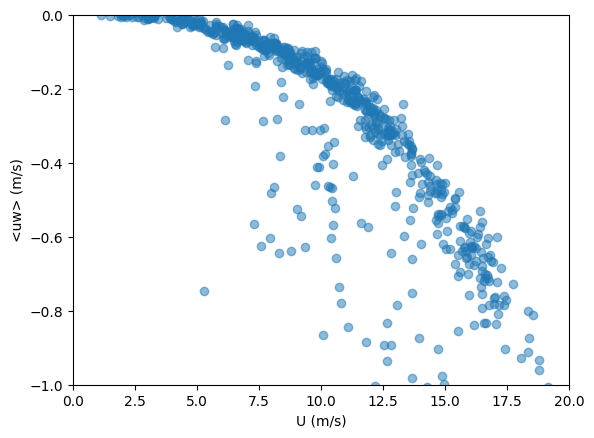

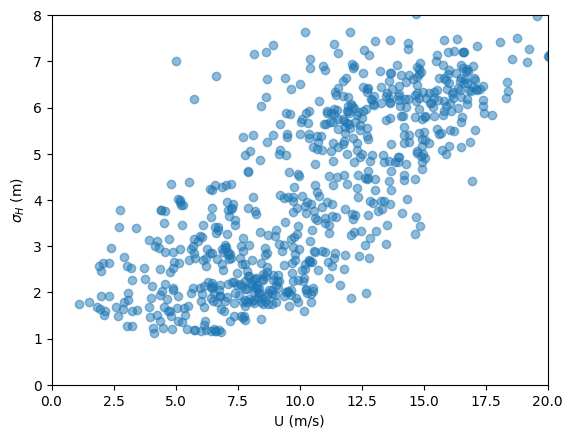

In [18]:
plot_x_velocity_vs_wind_speed(U, uw)
plot_wave_height_vs_wind_speed(U, sigH, x_max = 20.0, y_max=8.0)

## Get Telemetered data from kdata directory

Find all deployments, assemble and join datasets. This presumes that the initial datasets were recovered of some kind. If not, modify the code below to pick a different method (replace the 'telemetered' parameter in `load_kdata` below).

In [19]:
from ooi_data_explorations.common import load_kdata

deployments = {}
for file in file_list:
    deployment = file.split('deployment')[-1][:4]
    deployments['deployment'+deployment] = file

print("Deployments: {}".format(deployments.keys()))

# load datasets
telemetered_datasets = []
for deployment in deployments.keys():
    telemetered_datasets.append(load_kdata(site, node, sensor, 'telemetered', 'fdchp_a_dcl_instrument', tag= deployment + '*.nc'))

# join datasets
telemetered_dataset = xr.concat(telemetered_datasets, dim='time')

telemetered_dataset = telemetered_dataset.sel(time=slice(start_time_64, end_time_64))

Deployments: dict_keys(['deployment0010'])
Loading and Processing Data Files: 100%|██████████| 180/180 [00:01<00:00, 93.37it/s] 
Merging the data files into a single dataset


## Plot calculated vs telemetered

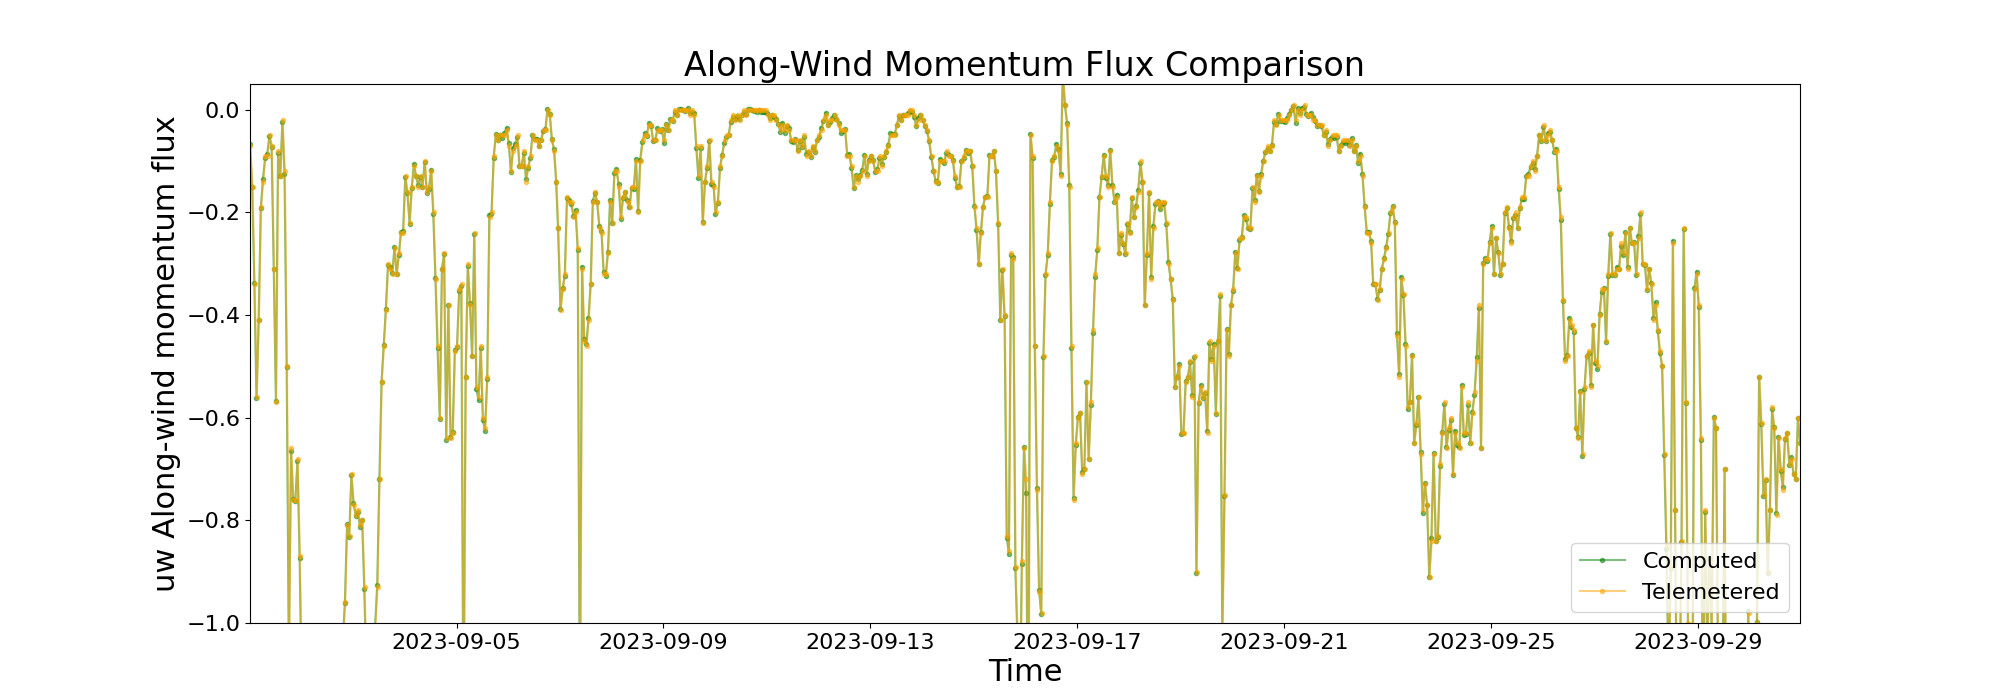

In [21]:
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
# %matplotlib inline
%matplotlib ipympl

marker_size = 3
legend_marker_size = 20
tick_size = 16

def update(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([legend_marker_size])
    
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(times, uw, marker='o',linestyle='solid',markersize=marker_size, color='green', alpha=0.5, label="Computed")

scatter = ax.plot(telemetered_dataset['time'], telemetered_dataset['uw_momentum_flux'], marker='o',linestyle='solid', color='orange', markersize=marker_size, alpha=0.5, label="Telemetered")
ax.set_xlabel('Time', fontsize=22)
ax.set_xlim(np.min(times), np.max(times))
ax.set_ylabel('uw Along-wind momentum flux', fontsize=22)
ax.set_ylim(-1.0, 0.05)
legend = ax.legend(loc="lower right", fontsize=tick_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title("Along-Wind Momentum Flux Comparison", fontsize=24)
# plt.savefig('calculated_vs_telemetered_comparison.png', bbox_inches='tight')
plt.show()